In [21]:
import hvplot.xarray
import numpy as np
import xarray as xr

In [22]:
def load_merged_argo_dataset_and_tumo(time_smoothing, lat_bounds = None):
    ds_argo_merged = xr.open_dataset(f'../rapid-geostrophic-reconstruction/data/ds_argo_{time_smoothing}_viking.nc')
    t_umo_obs = xr.open_dataset(f'../rapid-geostrophic-reconstruction/data/t_umo_sim_miss.nc')

    t_umo_obs = t_umo_obs.resample(time = time_smoothing).mean()

    ds_argo_merged = ds_argo_merged.sel(time = t_umo_obs.time.data)#, method = 'nearest')
    ds_argo_merged = ds_argo_merged.isel(z = slice(None, None, -1))

    if lat_bounds is not None:
        ds_argo_merged = ds_argo_merged.where((ds_argo_merged.lat >= lat_bounds[0]) & (ds_argo_merged.lat <= lat_bounds[1]))

    return ds_argo_merged, t_umo_obs

In [23]:
# Load the argo_dataset and the ground truth dataset

import xarray as xr
time_smoothing = '10D'

lat_bounds = (25, 27)


ds_argo_merged, t_umo_obs = load_merged_argo_dataset_and_tumo(time_smoothing)#, lat_bounds = lat_bounds)

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


## Single Profile Processing

We will load the ds_argo_merged dataset as thre base where each prfoile in the ten day window is present.
THen we will create 4 embedding one for each of the moorings and each profile is assigned by distance to those emebeddings. 
Each profile will create based on the currtent state and its rho values a delta that will be added to the embedding.

In [24]:
dv_dz_obs = xr.open_dataset('../rapid-geostrophic-reconstruction/data/dv_dz_sim_miss.nc')
dv_dz_obs = dv_dz_obs.resample(time = time_smoothing).mean()
dv_dz_obs.mean('time').dv_dz_times_X#.interpolate_na('z')

<xarray.DataArray 'dv_dz_times_X' (z: 242)>
array([-4.26155222e+00, -4.24931499e+00, -4.23704338e+00, -4.22473737e+00,
       -4.21239697e+00, -4.20002217e+00, -4.18761299e+00, -4.17516942e+00,
       -4.16269147e+00, -4.15017913e+00, -4.12677987e+00, -4.09149257e+00,
       -4.05641220e+00, -4.02153904e+00, -3.98687338e+00, -3.95241552e+00,
       -3.91816573e+00, -3.88412431e+00, -3.85029154e+00, -3.81666771e+00,
       -3.78325310e+00, -3.75004800e+00, -3.69914296e+00, -3.53196757e+00,
       -3.36598953e+00, -3.20120959e+00, -3.03762846e+00, -2.87524686e+00,
       -2.71406550e+00, -2.55408510e+00, -2.39530637e+00, -2.23773000e+00,
       -2.08135669e+00, -1.92618714e+00, -1.77222203e+00, -1.71365519e+00,
       -1.67177735e+00, -1.63020451e+00, -1.58893673e+00, -1.54797409e+00,
       -1.50731665e+00, -1.46696448e+00, -1.42691764e+00, -1.38717619e+00,
       -1.34774020e+00, -1.30860973e+00, -1.26978484e+00, -1.19602608e+00,
       -1.10366078e+00, -1.01193333e+00, -9.20843926e-01, -8.30392798e-01,
       -7.40580156e-01, -6.51406210e-01, -5.62871169e-01, -4.74975239e-01,
       -4.34449500e-01, -1.29240810e-01, -1.86909318e-01, -3.10485839e-01,
       -4.90687592e-01, -6.69924273e-01, -8.48196111e-01, -1.02550333e+00,
       -1.20184618e+00, -1.37722489e+00, -1.55163971e+00, -1.72509088e+00,
       -1.89757866e+00, -2.06910331e+00, -2.23966509e+00, -2.29538868e+00,
       -2.25332520e+00, -2.21165914e+00, -2.17038995e+00, -2.12951706e+00,
       -2.08903992e+00, -2.04895795e+00, -2.00927061e+00, -1.96997732e+00,
...
        2.02293375e+00,  2.03597691e+00,  2.04791773e+00,  2.05876471e+00,
        2.87722344e+00,  4.38290106e+00,  5.90328276e+00,  7.43837375e+00,
        8.98817960e+00,  1.05527062e+01,  1.21319600e+01,  1.37259475e+01,
        1.53346759e+01,  1.61476764e+01,  1.68588913e+01,  1.75716392e+01,
        1.82859349e+01,  1.90017932e+01,  1.97192286e+01,  2.04382562e+01,
        2.11588905e+01,  2.14051140e+01,  2.15666380e+01,  2.17300672e+01,
        2.18953974e+01,  2.20626241e+01,  2.22317430e+01,  2.24027497e+01,
        2.17793473e+01,  2.02187777e+01,  1.86468277e+01,  1.70634927e+01,
        1.54687674e+01,  1.38626466e+01,  1.22451245e+01,  8.69501827e+00,
        4.42142928e+00,  3.39850244e-02, -4.46658099e+00, -9.07955537e+00,
       -1.38042442e+01, -1.86874219e+01, -2.39791696e+01, -2.97000776e+01,
       -3.58447400e+01, -4.24079550e+01, -4.81271923e+01, -5.24269284e+01,
       -5.72960815e+01, -6.27267144e+01, -6.87111928e+01, -7.56068259e+01,
       -8.32339149e+01, -9.14356196e+01, -1.00204411e+02, -1.06406623e+02,
       -1.10959700e+02, -1.15689603e+02, -1.20221232e+02, -1.21710235e+02,
       -1.23181894e+02, -1.24578228e+02, -1.25404082e+02, -1.26150058e+02,
       -1.27961040e+02, -1.30645355e+02, -1.34685278e+02, -1.41319752e+02,
       -1.51120402e+02, -1.63480684e+02, -1.80562160e+02, -2.00542486e+02,
       -2.37206999e+02, -2.68564909e+02, -2.67373646e+02, -3.41307532e+02,
                   nan,             nan])
Coordinates:
  * z        (z) float64 -4.82e+03 -4.8e+03 -4.78e+03 ... -40.0 -20.0 -0.0

In [25]:
from copy import deepcopy

In [26]:
ds_argo_merged_10days, t_umo_10days = load_merged_argo_dataset_and_tumo('10D', lat_bounds = lat_bounds)

compartments = [
    ['west_p', -76.74, -70, 'west'],
    ['mar_west_p', -60, -47, 'east'],
    ['mar_east_p', -47, -40, 'west'],
    ['east_p', -30, -13.5, 'east']
]

# We only take the first 2000 meters depth
ds_argo_merged_10days = ds_argo_merged_10days.where(ds_argo_merged_10days.z > -2000, drop = True)

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [27]:
ds_argo_merged_10days

<xarray.Dataset>
Dimensions:       (time: 653, pos: 113, z: 29)
Coordinates:
  * time          (time) datetime64[ns] 2004-04-02 2004-04-12 ... 2022-02-07
  * pos           (pos) int64 0 1 2 3 4 5 6 7 ... 106 107 108 109 110 111 112
  * z             (z) float32 -3.047 -9.454 -16.36 ... -1.655e+03 -1.85e+03
    pressure      (z) float32 3.047 9.454 16.36 ... 1.471e+03 1.655e+03 1.85e+03
    lon           (time, pos) float32 -68.65 -34.7 -39.75 -47.6 ... nan nan nan
    lat           (time, pos) float32 27.5 28.55 29.68 26.28 ... nan nan nan nan
    time_1d       (time, pos) datetime64[ns] 2004-04-01T12:00:00 ... NaT
Data variables:
    temperature   (time, pos, z) float32 nan nan nan nan nan ... nan nan nan nan
    salinity      (time, pos, z) float32 nan nan nan nan nan ... nan nan nan nan
    profile_mask  (time, pos, z) float64 nan nan nan nan nan ... nan nan nan nan
    ct            (time, pos, z) float64 nan nan nan nan nan ... nan nan nan nan
    rho           (time, pos, z) float64 nan nan nan nan nan ... nan nan nan nan

In [28]:
# Prepare a dataset by 1) splitting the data, 2) scaling the input data 
train_slice_pos = 'start'

train_ratio = .6
val_ratio = .2


t_umo_10days = t_umo_10days.sel(time = slice(None, '2020-01-01'))
ds_argo_merged_10days = ds_argo_merged_10days.sel(time = slice(None, '2020-01-01'))


indices = np.arange(t_umo_10days.time.shape[0])
# np.random.shuffle(indices)

if train_slice_pos == 'start':
    train_indices = indices[:int(train_ratio * indices.shape[0])]
    val_indices = indices[int(train_ratio * indices.shape[0]):int((train_ratio + val_ratio) * indices.shape[0])]
    test_indices = indices[int((train_ratio + val_ratio) * indices.shape[0]):]
elif train_slice_pos == 'end':
    train_indices = indices[-int(train_ratio * indices.shape[0]):]
    val_indices = indices[-int((train_ratio + val_ratio) * indices.shape[0]): -int(train_ratio * indices.shape[0])]
    test_indices = indices[:-int((train_ratio + val_ratio) * indices.shape[0])]


rho_mean = ds_argo_merged_10days.where(ds_argo_merged_10days.profile_mask).mean(['time', 'pos']).rho
rho_std = ds_argo_merged_10days.where(ds_argo_merged_10days.profile_mask).isel(time = train_indices).std(['time', 'pos']).rho

temperature_mean = ds_argo_merged_10days.where(ds_argo_merged_10days.profile_mask).mean(['time', 'pos']).temperature
temperature_std = ds_argo_merged_10days.where(ds_argo_merged_10days.profile_mask).isel(time = train_indices).std(['time', 'pos']).temperature

salinity_mean = ds_argo_merged_10days.where(ds_argo_merged_10days.profile_mask).mean(['time', 'pos']).salinity
salinity_std = ds_argo_merged_10days.where(ds_argo_merged_10days.profile_mask).isel(time = train_indices).std(['time', 'pos']).salinity



def standardize_rho(ds_pos, rho_mean=None, rho_std=None):
    ds_pos = deepcopy(ds_pos)
    ds_pos["rho"] = (ds_pos["rho"] - rho_mean) / rho_std
    return ds_pos

def standardize_temperature(ds_pos, temperature_mean=None, temperature_std=None):
    ds_pos = deepcopy(ds_pos)
    ds_pos["temperature"] = (ds_pos["temperature"] - temperature_mean) / temperature_std
    return ds_pos

def standardize_salinity(ds_pos, salinity_mean=None, salinity_std=None):
    ds_pos = deepcopy(ds_pos)
    ds_pos["salinity"] = (ds_pos["salinity"] - salinity_mean) / salinity_std
    return ds_pos


ds_argo_merged_10days_std = standardize_rho(
    ds_argo_merged_10days,
    rho_mean=rho_mean, 
    rho_std=rho_std,
)

ds_argo_merged_10days_std = standardize_temperature(
    ds_argo_merged_10days_std,
    temperature_mean=temperature_mean,
    temperature_std=temperature_std,
)

ds_argo_merged_10days_std = standardize_salinity(
    ds_argo_merged_10days_std,
    salinity_mean=salinity_mean,
    salinity_std=salinity_std,
)

ds_argo_merged_10days_std = ds_argo_merged_10days_std.fillna(0)

nn_feature_ds = xr.concat(
    [
        ds_argo_merged_10days_std.rho, 
        ds_argo_merged_10days_std.temperature, 
        ds_argo_merged_10days_std.salinity], dim = 'feature'
).stack(nn_feature = ['feature', 'z'])
train_X_scaled = nn_feature_ds.isel(time = train_indices).values
val_X_scaled = nn_feature_ds.isel(time = val_indices).values
test_X_scaled = nn_feature_ds.isel(time = test_indices).values


train_X_mask = ds_argo_merged_10days.isel(time = train_indices).profile_mask.fillna(0).astype(bool).values
val_X_mask = ds_argo_merged_10days.isel(time = val_indices).profile_mask.fillna(0).astype(bool).values
test_X_mask = ds_argo_merged_10days.isel(time = test_indices).profile_mask.fillna(0).astype(bool).values

train_X_lon = ds_argo_merged_10days.isel(time = train_indices).lon.values
val_X_lon = ds_argo_merged_10days.isel(time = val_indices).lon.values
test_X_lon = ds_argo_merged_10days.isel(time = test_indices).lon.values

train_X_days = (ds_argo_merged_10days.isel(time = train_indices).time_1d - ds_argo_merged_10days.isel(time = train_indices).time).dt.days.values
val_X_days = (ds_argo_merged_10days.isel(time = val_indices).time_1d - ds_argo_merged_10days.isel(time = val_indices).time).dt.days.values
test_X_days = (ds_argo_merged_10days.isel(time = test_indices).time_1d - ds_argo_merged_10days.isel(time = test_indices).time).dt.days.values

train_y = t_umo_10days.isel(time = train_indices).dv_dz_times_X.values
val_y = t_umo_10days.isel(time = val_indices).dv_dz_times_X.values
test_y = t_umo_10days.isel(time = test_indices).dv_dz_times_X.values

mean_tranport = np.mean(train_y, axis = 0)
std_transport = np.std(train_y, axis = 0)

train_y_scaled = (train_y - mean_tranport) / std_transport
val_y_scaled = (val_y - mean_tranport) / std_transport
test_y_scaled = (test_y - mean_tranport) / std_transport

dv_dz_obs = xr.open_dataset('../rapid-geostrophic-reconstruction/data/dv_dz_sim_miss.nc')
dv_dz_obs = dv_dz_obs.resample(time = time_smoothing).mean()
dv_dz_moorings = dv_dz_obs.sel(time = ds_argo_merged_10days.time).where(dv_dz_obs.z <= -2000, drop = True)

mean_dv_dz_moorings = dv_dz_moorings.isel(time = train_indices).mean(['time']).dv_dz_times_X
std_dv_dz_moorings = dv_dz_moorings.isel(time = train_indices).std(['time']).dv_dz_times_X

train_dv_dz_moorings_scaled = ((dv_dz_moorings.isel(time = train_indices).dv_dz_times_X - mean_dv_dz_moorings) / std_dv_dz_moorings).fillna(0).values
val_dv_dz_moorings_scaled = ((dv_dz_moorings.isel(time = val_indices).dv_dz_times_X - mean_dv_dz_moorings) / std_dv_dz_moorings).fillna(0).values
test_dv_dz_moorings_scaled = ((dv_dz_moorings.isel(time = test_indices).dv_dz_times_X - mean_dv_dz_moorings) / std_dv_dz_moorings).fillna(0).values



ds_argo_merged_10days


/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/xarray/core/accessor_dt.py:122: RuntimeWarning: invalid value encountered in cast
  return access_method(values, name).astype(dtype, copy=False)


<xarray.Dataset>
Dimensions:       (time: 576, pos: 113, z: 29)
Coordinates:
  * time          (time) datetime64[ns] 2004-04-02 2004-04-12 ... 2019-12-30
  * pos           (pos) int64 0 1 2 3 4 5 6 7 ... 106 107 108 109 110 111 112
  * z             (z) float32 -3.047 -9.454 -16.36 ... -1.655e+03 -1.85e+03
    pressure      (z) float32 3.047 9.454 16.36 ... 1.471e+03 1.655e+03 1.85e+03
    lon           (time, pos) float32 -68.65 -34.7 -39.75 -47.6 ... nan nan nan
    lat           (time, pos) float32 27.5 28.55 29.68 26.28 ... nan nan nan nan
    time_1d       (time, pos) datetime64[ns] 2004-04-01T12:00:00 ... NaT
Data variables:
    temperature   (time, pos, z) float32 nan nan nan nan nan ... nan nan nan nan
    salinity      (time, pos, z) float32 nan nan nan nan nan ... nan nan nan nan
    profile_mask  (time, pos, z) float64 nan nan nan nan nan ... nan nan nan nan
    ct            (time, pos, z) float64 nan nan nan nan nan ... nan nan nan nan
    rho           (time, pos, z) float64 nan nan nan nan nan ... nan nan nan nan

In [29]:
from torch.utils.data import DataLoader, TensorDataset, Dataset
class ProfileDataset(Dataset):
    def __init__(self, X, y, mask, lon, dv_dz, days, compartments):
        self.X = X
        self.y = y
        self.mask = mask
        self.lon = lon
        self.days = days
        self.compartment = compartments 
        self.dv_dz = dv_dz

        self.len_compartments = len(compartments)

        self.X_per_compartment = []
        self.lon_per_compartment = []
        self.dv_dz_per_compartment = []
        self.days_per_compartment = []

        self.min_longitude = min([comp[1] for comp in compartments])
        self.max_longitude = max([comp[2] for comp in compartments])


        self.max_days = 5

        self.lon_scaled = (self.lon - self.min_longitude) / (self.max_longitude - self.min_longitude)
        self.days_scaled = self.days / self.max_days
        
        for i in range(len(self)):
            mask = self.mask[i]


            compartment_X_per_sample = []
            compartment_lon_per_sample = []
            compartment_days_per_sample = []

            for j in range(self.len_compartments):

                # get all profile indices that are in the compartment and in the mask 
                profile_indices = np.where((self.lon[i] > self.compartment[j][1]) & (self.lon[i] < self.compartment[j][2]) & mask.any(axis = -1))[0]

                if len(profile_indices) < 1:
                    compartment_X_per_sample.append(np.empty(0))
                    compartment_lon_per_sample.append(np.empty(0))
                    compartment_days_per_sample.append(np.empty(0))
                    continue

                lon_compartments = self.lon_scaled[i][profile_indices]
                sorted_indices_longitude = lon_compartments.argsort()


                # If I have the sequence -5, -15, 5 the argsort will return [1, 0, 2]
                # As we want to have those profiles as last that are closes to the mooring due to the vanishing gradient 
                # For West moorings the smallest value has to be the last one
                if self.compartment[j][3] == 'west':
                    sorted_indices_longitude = sorted_indices_longitude[::-1]
                
                profile_indices = profile_indices[sorted_indices_longitude]

                compartment_X_per_sample.append(self.X[i][ profile_indices])
                compartment_lon_per_sample.append(self.lon[i][profile_indices])
                compartment_days_per_sample.append(self.days_scaled[i][profile_indices])
            

            self.X_per_compartment.append(compartment_X_per_sample)
            self.lon_per_compartment.append(compartment_lon_per_sample)
            self.dv_dz_per_compartment.append(self.dv_dz[i])
            self.days_per_compartment.append(compartment_days_per_sample)


    def __len__(self):
        return self.X.shape[0] 

    def __getitem__(self, idx):
        return self.X_per_compartment[idx], self.y[idx], self.lon_per_compartment[idx], self.dv_dz_per_compartment[idx], self.days_per_compartment[idx]

In [30]:
train_X_lon.shape

(345, 113)

In [31]:
import torch
train_dataset = ProfileDataset(train_X_scaled, train_y, train_X_mask, train_X_lon, train_dv_dz_moorings_scaled, train_X_days, compartments)
val_dataset = ProfileDataset(val_X_scaled, val_y, val_X_mask, val_X_lon, val_dv_dz_moorings_scaled, val_X_days, compartments)
test_dataset = ProfileDataset(test_X_scaled, test_y, test_X_mask, test_X_lon, test_dv_dz_moorings_scaled, test_X_days, compartments)


def merge_profiles(data):
    """
        X: is a list and each entry is a list of compartments in which the profiles are stored with variable length
    """
    X, y, lon, dv_dz, days = zip(*data)
    X = [[torch.tensor(x_compartment).float() for x_compartment in x_sample] for x_sample in X]
    y = torch.tensor(np.array(y)).float()
    lon = [[torch.tensor(lon_compartment).float() for lon_compartment in lon_sample] for lon_sample in lon]
    dv_dz = [torch.tensor(dv_dz_sample).float() for dv_dz_sample in dv_dz]
    days = [[torch.tensor(days_compartment).float() for days_compartment in day_sample] for day_sample in days]

    return X, y, lon, dv_dz, days

dl = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=merge_profiles)
val_dl = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=merge_profiles)
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=merge_profiles)


In [50]:
from torch import nn

class PredictionToTransportModel(nn.Module):

    def __init__(self, z_scale, mean_per_z, std_per_z ):
        super(PredictionToTransportModel, self).__init__()
        self.mean_per_z = torch.tensor(mean_per_z).float()
        self.std_per_z = torch.tensor(std_per_z).float()
        self.bottom_index = np.argmin(np.abs(z_scale - -4800).values)
        self.amoc_index = np.argmin(np.abs(z_scale - -1000).values)

    def forward(self, x):
        x = x * self.std_per_z + self.mean_per_z

        dv_dz_prediction = x

        return (
            -((torch.cumsum(dv_dz_prediction.flip(-1), -1) * 20) -
            (torch.cumsum(dv_dz_prediction.flip(-1), -1) * 20).flip(-1)[:, [self.bottom_index]]).cumsum(-1) * 20 / 1e6
        ).flip(-1)[:, self.amoc_index]


class CompartmentModel(nn.Module):

    def __init__(self, n_features, n_embedding):
        super(CompartmentModel, self).__init__()
        self.n_features = n_features
        self.n_embedding = n_embedding
        self.fc1 = nn.Linear(n_features + n_embedding + 1 + 1, 256)
        self.fc2 = nn.Linear(256, 128)
        self.dropout1 = nn.Dropout(p=.015)
        self.fc3 = nn.Linear(128, n_embedding)
        self.dropout2 = nn.Dropout(p=.15)
        self.fc4 = nn.Linear(n_embedding, n_embedding)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class ProfileModel(nn.Module):
    def __init__(self, n_features, n_compartments, n_embedding, n_dvdz_features, z_scale):
        super(ProfileModel, self).__init__()
        self.n_compartments = n_compartments
        self.n_features = n_features
        self.n_dvdz_features = n_dvdz_features
        self.n_embedding = n_embedding
        self.fc1 = nn.Linear(n_embedding * n_compartments +n_dvdz_features  , 256)
        self.bn1 = nn.BatchNorm1d(num_features=256)
        self.fc2 = nn.Linear(256,128)
        self.dropout1 = nn.Dropout(p=.25)
        self.fc3 = nn.Linear(128,64)
        self.dropout2 = nn.Dropout(p=.33)
        self.fc4 = nn.Linear(64,64)
        self.bn2 = nn.BatchNorm1d(num_features=64)
        self.dropout3 = nn.Dropout(p=.2)
        self.fc5 = nn.Linear(64,32)
        self.fc6 = nn.Linear(32,242)

        self.compartment_models = nn.ModuleList([CompartmentModel(n_features, n_embedding) for _ in range(n_compartments)])
        self.transformer = PredictionToTransportModel(z_scale, dv_dz_obs.dv_dz_times_X.mean('time').fillna(0).values, dv_dz_obs.dv_dz_times_X.std('time').fillna(1).values)

    def forward(self, x, lon, dv_dz, days):

        
        batch_embeddings = []
        for batch_i in range(len(x)):
            compartment_embeddings = []
            x_batch = x[batch_i]
            for i in range(self.n_compartments):
                x_compartment = x_batch[i]
                compartment_embedding = torch.zeros(self.n_embedding).float()
                compartment_embeddings_for_mean = []
                for x_profile, lon_profile, day_profile in zip(x_compartment, lon[batch_i][i], days[batch_i][i]):
                    
                    input_to_compartment_embedding = torch.cat([x_profile, compartment_embedding, lon_profile.unsqueeze(0), day_profile.unsqueeze(0)]).float()
                    

                    
                    compartment_embedding = compartment_embedding + self.compartment_models[i](input_to_compartment_embedding).float()
                    # compartment_embeddings_for_mean.append(self.compartment_models[i](input_to_compartment_embedding).float())
                
                # if len(compartment_embeddings_for_mean) < 1:
                #     compartment_embedding = torch.zeros(self.n_embedding).float()
                # else:
                #     compartment_embedding = torch.stack(compartment_embeddings_for_mean).mean(dim = 0)    
                if len(x_compartment) > 0:
                    compartment_embedding /= len(x_compartment)
                compartment_embeddings.append(compartment_embedding)

            embedding_all_profiles = torch.concat(compartment_embeddings +[dv_dz[batch_i]], dim = 0)
            batch_embeddings.append(embedding_all_profiles)
        embedding_all_profiles = torch.stack(batch_embeddings)
        assert not torch.isnan(embedding_all_profiles).any(), 'NaN in embedding_all_profiles'
        x = torch.relu(self.fc1(embedding_all_profiles))
        # x = self.bn1(x)
        # x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = torch.relu(self.fc4(x))
        # x = self.bn2(x)
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        x = x.squeeze(dim = -1)

        return self.transformer(x)
        



In [51]:
model = ProfileModel(train_X_scaled.shape[2], len(compartments), 64, train_dv_dz_moorings_scaled.shape[1], ds_argo_merged_10days.z)
model.float()
for X, y, lon, dvdz, days in dl:
    print(model(X, lon, dvdz, days).squeeze(), y)
    break

tensor([-23.8649, -23.8616, -23.8664, -23.8652], grad_fn=<SqueezeBackward0>) tensor([-18.2669, -17.5786, -18.2614, -12.5378])


In [52]:
from torch import optim

torch.random.manual_seed(42)
np.random.seed(42)


model = ProfileModel(train_X_scaled.shape[2], len(compartments), 128, train_dv_dz_moorings_scaled.shape[1] , ds_argo_merged_10days.z)
model.float()
criterion = nn.MSELoss()
# criterion = nn.L1Loss()
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-10, momentum=.9)
num_epochs = 100
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

best_val_loss = 1e10
best_model = None
best_epoch = 0

for epoch in range(num_epochs):  # loop over the dataset multiple times

    model.train()
    loss_per_epoch = 0.0
    for i, data in enumerate(dl, 0):
        # get the inputs; data is a list of [inputs, labels]
        X, y, lon, dvdz, days = data
        

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(X, lon, dvdz, days)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        # print statistics
        loss_per_epoch += loss.item()

    lr_scheduler.step()

    model.eval()
    total_val_loss = 0.
    for X, y, lon, dvdz, days in val_dl:
        val_prediction = model(X, lon, dvdz, days).detach()
        val_loss = criterion(val_prediction, y).item()

        total_val_loss += val_loss

    total_val_loss /= len(val_dl)
    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        best_epoch = epoch
        best_model = deepcopy(model)
        print('New best model found in epoch: ', epoch, 'with val loss: ', total_val_loss)

    if (epoch+1) % 3 == 0:
        print(f'Epoch {epoch}, Loss: {loss_per_epoch / len(dl)}, Val loss: {total_val_loss}')

    if epoch - best_epoch > 20:
        break


New best model found in epoch:  0 with val loss:  11.31589823961258
New best model found in epoch:  1 with val loss:  9.778468132019043
Epoch 2, Loss: 11.639106110123725, Val loss: 10.857116341590881
New best model found in epoch:  4 with val loss:  9.685095429420471
Epoch 5, Loss: 11.607504978947256, Val loss: 10.717140018939972
New best model found in epoch:  8 with val loss:  7.171647250652313
Epoch 8, Loss: 9.985441404512558, Val loss: 7.171647250652313
Epoch 11, Loss: 10.122279546726709, Val loss: 9.423267424106598
Epoch 14, Loss: 9.140444264329712, Val loss: 10.083804786205292
New best model found in epoch:  15 with val loss:  6.405393004417419
Epoch 17, Loss: 9.995196917276273, Val loss: 8.71475625038147
Epoch 20, Loss: 8.05706338807084, Val loss: 6.8138591051101685
Epoch 23, Loss: 7.503460283937125, Val loss: 6.817692756652832
Epoch 26, Loss: 7.061507105142221, Val loss: 12.489818692207336
New best model found in epoch:  29 with val loss:  6.052386045455933
Epoch 29, Loss: 7.24

In [53]:
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=merge_profiles)

test_predictions = []

model = best_model
model.eval()
total_test_loss = 0.

for X, y, lon, dvdz, days in test_dl:

    test_prediction = model(X, lon, dvdz, days).detach()
    test_loss = criterion(test_prediction, y).item()

    total_test_loss += test_loss
    test_predictions.append(test_prediction)

test_predictions = torch.cat(test_predictions)

# test_predictions = (test_predictions * std_transport) + mean_tranport

In [54]:
argo_numbers_per_compartment = np.empty((len(test_dataset), len(compartments)))

for i, (x, _, _, _, _) in enumerate(test_dataset):
    for j, x_compartment in enumerate(x):
        argo_numbers_per_compartment[i, j] = len(x_compartment)


argo_numbers_per_compartment = xr.DataArray(
    argo_numbers_per_compartment,
    coords = {
        'time': t_umo_10days.time.isel(time = test_indices)
    },
    dims = ['time', 'compartment'],
    name = 'argo_numbers_per_compartment'
)

In [55]:


transport = xr.DataArray(
    test_predictions,
    coords={
        'time':ds_argo_merged_10days_std.isel(time = test_indices).time
    }, name='dv_dz_times_X')
(
    (   
    transport.hvplot(label = 'NN')
        * t_umo_obs.sel(time = transport.time, method = 'nearest').hvplot(label = 'rapid')
        # * t_merged_argo_2000.sel(time = transport.time, method = 'nearest').hvplot(label = 'argo')
) +

(
    argo_numbers_per_compartment.isel(compartment = 0).hvplot(label = compartments[0][0]) *
    argo_numbers_per_compartment.isel(compartment = 1).hvplot(label = compartments[1][0]) *
    argo_numbers_per_compartment.isel(compartment = 2).hvplot(label = compartments[2][0]) *
    argo_numbers_per_compartment.isel(compartment = 3).hvplot(label = compartments[3][0])
)


).cols(1)

:Layout
   .Overlay.I  :Overlay
      .Curve.NN    :Curve   [time]   (dv_dz_times_X)
      .Curve.Rapid :Curve   [time]   (dv_dz_times_X)
   .Overlay.II :Overlay
      .Curve.West_p     :Curve   [time]   (argo_numbers_per_compartment)
      .Curve.Mar_west_p :Curve   [time]   (argo_numbers_per_compartment)
      .Curve.Mar_east_p :Curve   [time]   (argo_numbers_per_compartment)
      .Curve.East_p     :Curve   [time]   (argo_numbers_per_compartment)

In [56]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
const_prediction_MAE = np.abs(t_umo_obs.sel(time = transport.time, method = "nearest").dv_dz_times_X - t_umo_obs.sel(time = ds_argo_merged_10days_std.isel(time = train_indices).time, method = "nearest").dv_dz_times_X.mean()).mean().values

mae_error = mean_absolute_error(t_umo_obs.sel(time = transport.time, method = "nearest").dv_dz_times_X.values, transport.values)

print(f'R2: {r2_score(t_umo_obs.sel(time = transport.time, method = "nearest").dv_dz_times_X.values, transport.values)}')
print(f'MAE: {mae_error}; const MAE {const_prediction_MAE}', f' improvement percentage:  {(const_prediction_MAE - mae_error) / const_prediction_MAE * 100:.2f}%')
print(f'MSE: {mean_squared_error(t_umo_obs.sel(time = transport.time, method = "nearest").dv_dz_times_X.values, transport.values)}')

R2: 0.5443783620844151
MAE: 1.771663857412407; const MAE 2.8330195211352  improvement percentage:  37.46%
MSE: 5.479863681719989


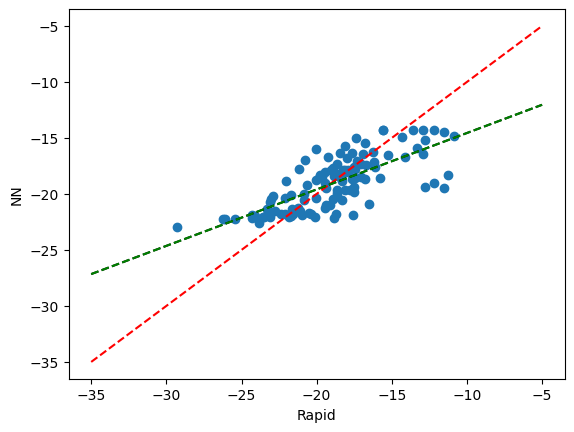

In [57]:
import matplotlib.pyplot as plt
plt.scatter(t_umo_obs.sel(time = transport.time, method = "nearest").dv_dz_times_X.values, transport.values)
# plt.scatter(t_umo_obs.sel(time = transport.time, method = "nearest").dv_dz_times_X.values, t_merged_argo_2000.sel(time = transport.time, method = 'nearest').values)
plt.xlabel('Rapid')
plt.ylabel('NN')
plt.plot([-35, -5], [-35, -5], 'r--')

from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(t_umo_obs.sel(time = transport.time, method = "nearest").dv_dz_times_X.values.reshape(-1, 1), transport.values.reshape(-1, 1))
in_X = np.linspace(-35, -5, 100).reshape(-1, 1)
plt.plot(in_X, lr.predict(in_X), 'k--')
# lr = LinearRegression().fit(t_umo_obs.sel(time = transport.time, method = "nearest").dv_dz_times_X.values.reshape(-1, 1), t_merged_argo_2000.sel(time = transport.time, method = 'nearest').values.reshape(-1, 1))
in_X = np.linspace(-35, -5, 100).reshape(-1, 1)
plt.plot(in_X, lr.predict(in_X), 'g--')

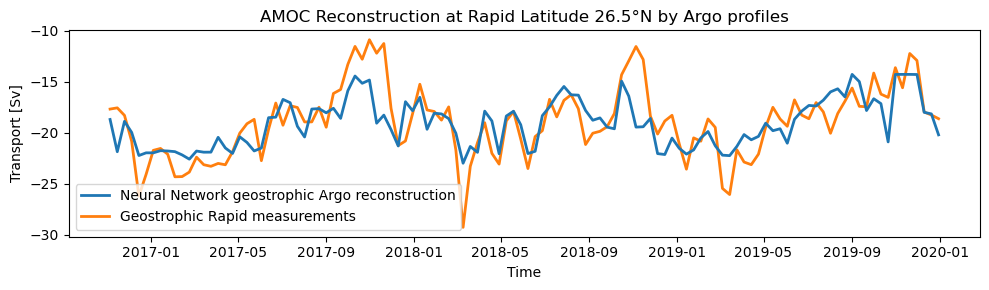

In [58]:
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(1,1,1)

# calc = t_merged_argo_2000.sel(time = transport.time, method = 'nearest')
# ax.plot(calc.time, calc.values, label = 'Geostrohphic calculation from Argos', alpha = .5, color = 'black')
rapid = t_umo_obs.sel(time = transport.time, method = 'nearest')
ax.plot(transport.time, transport.values, label = 'Neural Network geostrophic Argo reconstruction', linewidth = 2, zorder = 20)
ax.plot(rapid.time, rapid.dv_dz_times_X.values, label = 'Geostrophic Rapid measurements', linewidth = 2)

plt.legend()
ax.set_ylabel('Transport [Sv]')
ax.set_xlabel('Time')
plt.title('AMOC Reconstruction at Rapid Latitude 26.5°N by Argo profiles')
fig.tight_layout()
plt.savefig('argo_nn_reconstruction.png')

In [60]:
1

1